In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression,ElasticNetCV,\
RidgeCV,LassoCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, \
cross_val_predict,GridSearchCV,cross_validate
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

In [2]:
df = pd.read_csv("../data/train.csv")
df.head(3)

C:\Users\zttan\AppData\Local\Temp\ipykernel_17352\76928430.py:1: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/train.csv")


id Tranc_YearMonth             town  flat_type block       street_name  \
0   88471         2016-05  KALLANG/WHAMPOA     4 ROOM    3B  UPP BOON KENG RD   
1  122598         2012-07           BISHAN     5 ROOM   153      BISHAN ST 13   
2  170897         2013-07      BUKIT BATOK  EXECUTIVE  289B    BT BATOK ST 25   

  storey_range  floor_area_sqm flat_model  lease_commence_date  ...  vacancy  \
0     10 TO 12            90.0    Model A                 2006  ...       78   
1     07 TO 09           130.0   Improved                 1987  ...       45   
2     13 TO 15           144.0  Apartment                 1997  ...       39   

   pri_sch_affiliation  pri_sch_latitude  pri_sch_longitude  \
0                    1          1.317659         103.882504   
1                    1          1.349783         103.854529   
2                    0          1.345245         103.756265   

   sec_sch_nearest_dist                             sec_sch_name  \
0           1138.633422                 Geylang Methodist School   
1            447.894399  Kuo Chuan Presbyterian Secondary School   
2            180.074558             Yusof Ishak Secondary School   

   cutoff_point affiliation sec_sch_latitude  sec_sch_longitude  
0           224           0         1.317659         103.882504  
1           232           0         1.350110         103.854892  
2           188           0         1.342334         103.760013  

[3 rows x 77 columns]

In [3]:
# Check shape, nulls,zeroes and data type
print(f"Data frame shape: {df.shape}")
print("\n")
nulls = {k:v for k,v in dict(df.isnull().sum()).items() if v>0}
for k,v in nulls.items():
    print(f"Empty rows in column [{k}]: {v}")
print("\n")
zeroes = {k:v for k,v in dict(df[df == 0].count()).items() if v>0}
for k,v in zeroes.items():
    print(f"Rows with zeroes in column [{k}]: {v}")
print("\n")

column_types = {str(k):list(v) for k,v in df.groupby(df.dtypes,axis=1)}
for k,v in column_types.items():
    print(f"Columns with data type [{k}]:{v}")
    print("\n")

Data frame shape: (150634, 77)


Empty rows in column [Mall_Nearest_Distance]: 829
Empty rows in column [Mall_Within_500m]: 92789
Empty rows in column [Mall_Within_1km]: 25426
Empty rows in column [Mall_Within_2km]: 1940
Empty rows in column [Hawker_Within_500m]: 97390
Empty rows in column [Hawker_Within_1km]: 60868
Empty rows in column [Hawker_Within_2km]: 29202


Rows with zeroes in column [1room_sold]: 150552
Rows with zeroes in column [2room_sold]: 144324
Rows with zeroes in column [3room_sold]: 95671
Rows with zeroes in column [4room_sold]: 30379
Rows with zeroes in column [5room_sold]: 62782
Rows with zeroes in column [exec_sold]: 124614
Rows with zeroes in column [multigen_sold]: 150557
Rows with zeroes in column [studio_apartment_sold]: 149226
Rows with zeroes in column [1room_rental]: 150332
Rows with zeroes in column [2room_rental]: 148770
Rows with zeroes in column [3room_rental]: 146805
Rows with zeroes in column [other_room_rental]: 150602
Rows with zeroes in column [Mall_

In [4]:
# generate new hdb age at tranc column:
df['hdb_age_at_tranc'] = df['Tranc_Year']-df['lease_commence_date']

In [5]:
# Let's impute missing values with the mean
col = ['Hawker_Within_2km','Mall_Within_2km', 'Mall_Nearest_Distance' ]
for i in col:
    mean = np.mean(df[i])
    df[i].fillna(value=mean, inplace=True)

In [6]:
# Get features columns
import csv

numerical_columns = []
categorical_columns = []

filename = "../data/data_dictionary_analysis.csv"
with open(filename,'r') as data:
    reader = csv.reader(data)
    next(reader, None)  # skip the headers
    for line in reader:
        if line[3]=='1' and line[4] == 'numerical':
            numerical_columns.append(line[1])
        if line[3]=='1' and line[4] == 'Categorical':
            categorical_columns.append(line[1])


In [7]:
for i in numerical_columns:
    print(f"Column [{i}] has data type [{df[i].dtype}]")

Column [floor_area_sqm] has data type [float64]
Column [Tranc_Year] has data type [int64]
Column [mid] has data type [int64]
Column [max_floor_lvl] has data type [int64]
Column [Mall_Nearest_Distance] has data type [float64]
Column [Mall_Within_2km] has data type [float64]
Column [Hawker_Nearest_Distance] has data type [float64]
Column [Hawker_Within_2km] has data type [float64]
Column [mrt_nearest_distance] has data type [float64]
Column [cutoff_point] has data type [int64]
Column [hdb_age_at_tranc] has data type [int64]


In [8]:
for i in categorical_columns:
    print(f"Column [{i}] has data type [{df[i].dtype}] has unique counts [{len(set(df[i]))}]")

Column [flat_type] has data type [object] has unique counts [7]
Column [flat_model] has data type [object] has unique counts [20]
Column [planning_area] has data type [object] has unique counts [32]
Column [bus_interchange] has data type [int64] has unique counts [2]
Column [mrt_interchange] has data type [int64] has unique counts [2]


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5]),
 [Text(0.5, 0, 'floor_area_sqm'),
  Text(1.5, 0, 'Tranc_Year'),
  Text(2.5, 0, 'mid'),
  Text(3.5, 0, 'max_floor_lvl'),
  Text(4.5, 0, 'Mall_Nearest_Distance'),
  Text(5.5, 0, 'Mall_Within_2km'),
  Text(6.5, 0, 'Hawker_Nearest_Distance'),
  Text(7.5, 0, 'Hawker_Within_2km'),
  Text(8.5, 0, 'mrt_nearest_distance'),
  Text(9.5, 0, 'cutoff_point'),
  Text(10.5, 0, 'hdb_age_at_tranc')])

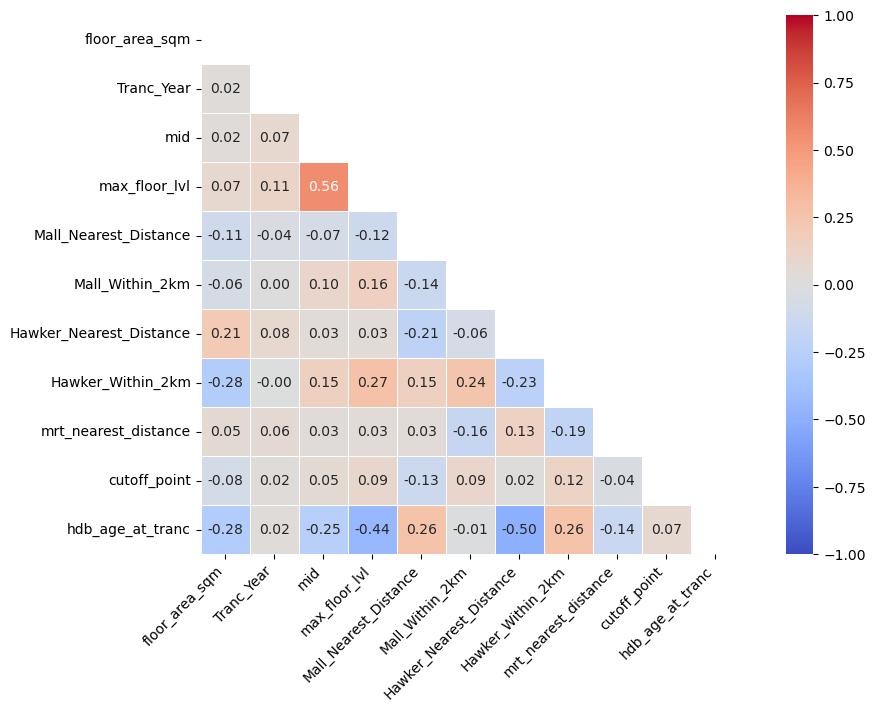

In [9]:
# Use Seaborn's heatmap with pandas .corr() to visualize correlations between all numeric features.
corr = df[numerical_columns].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize = (12,7))
sns.heatmap(corr, mask = mask, square = True, annot = True, vmin = -1, vmax = 1, linewidths = .5, cmap = "coolwarm",fmt='.2f')
plt.xticks(rotation=45, ha='right') 

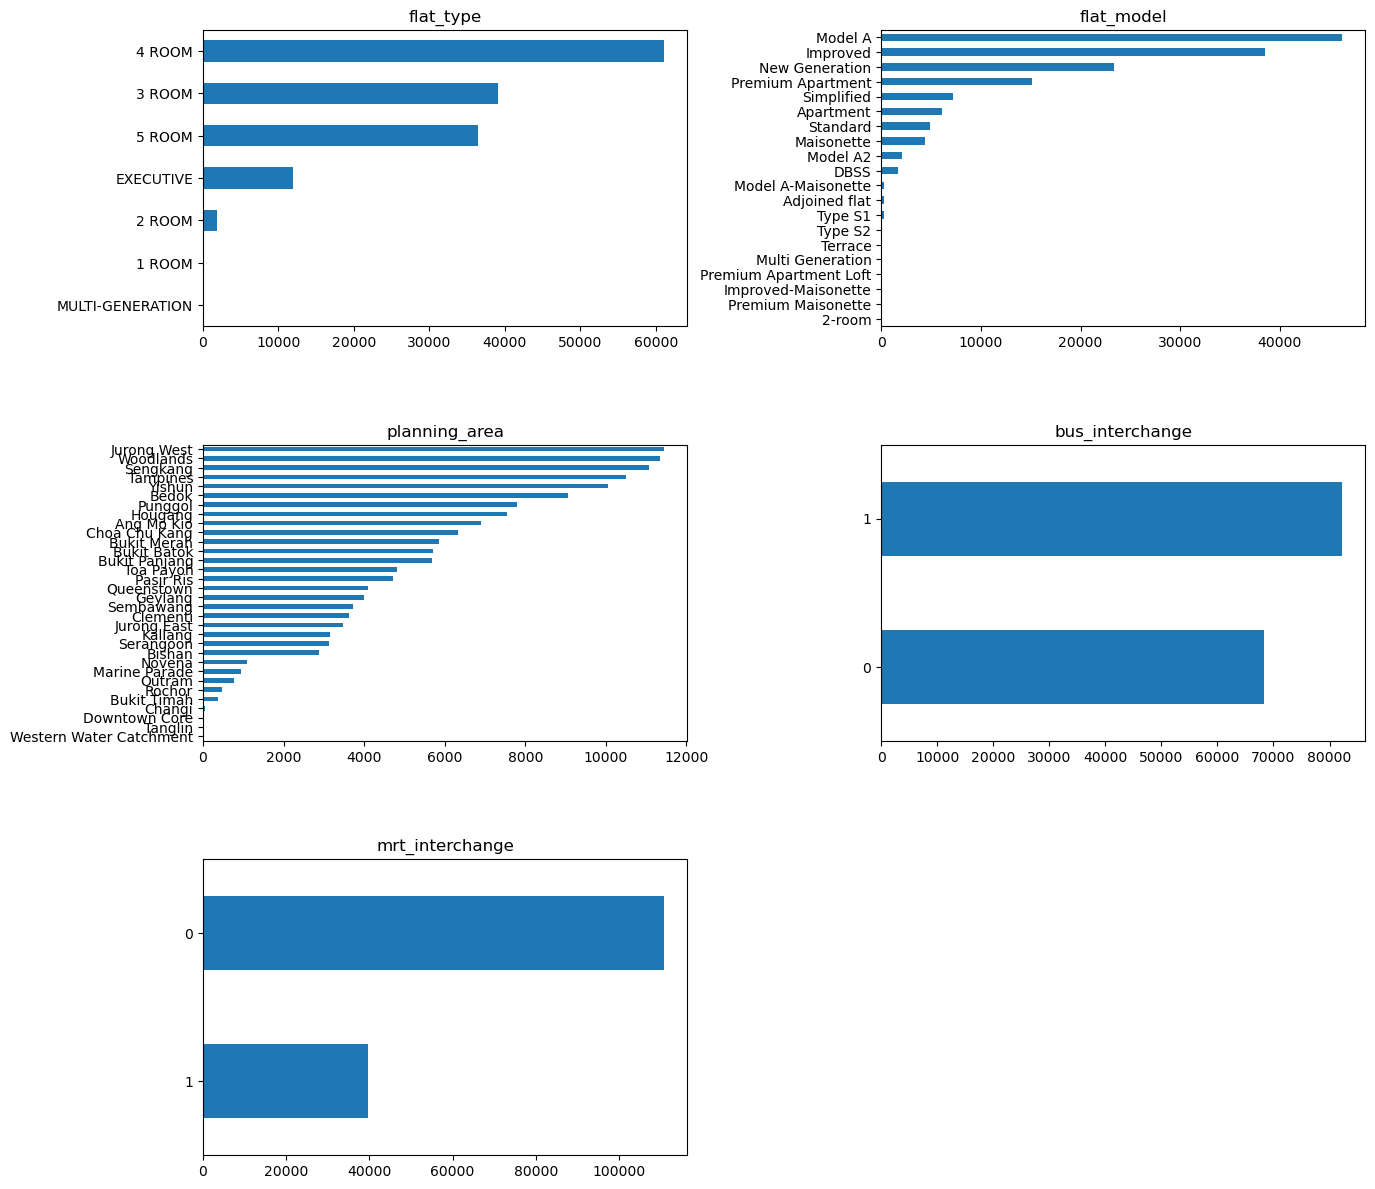

In [10]:
# Visualize categories
fig1 = plt.figure(figsize=(15,20))
fig1.subplots_adjust(hspace=0.4,wspace=0.4)

for idx, d in enumerate(categorical_columns):
    fig1.add_subplot(4,2,idx+1)
    df[d].value_counts().sort_values().plot(kind='barh')
    plt.title(d)

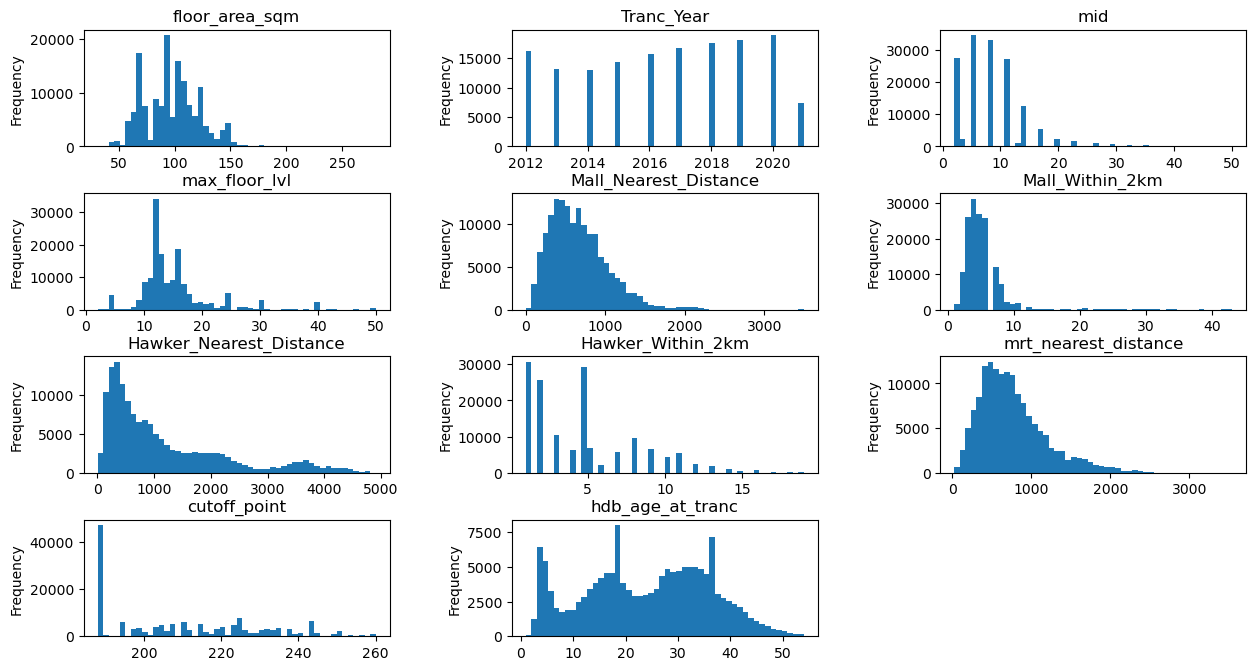

In [11]:
fig1b = plt.figure(figsize=(15,10))
fig1b.subplots_adjust(hspace=0.4,wspace=0.4)

for idx, d in enumerate(numerical_columns):
    fig1b.add_subplot(5,3,idx+1)
    df[d].plot(kind='hist',bins=50,title=d)

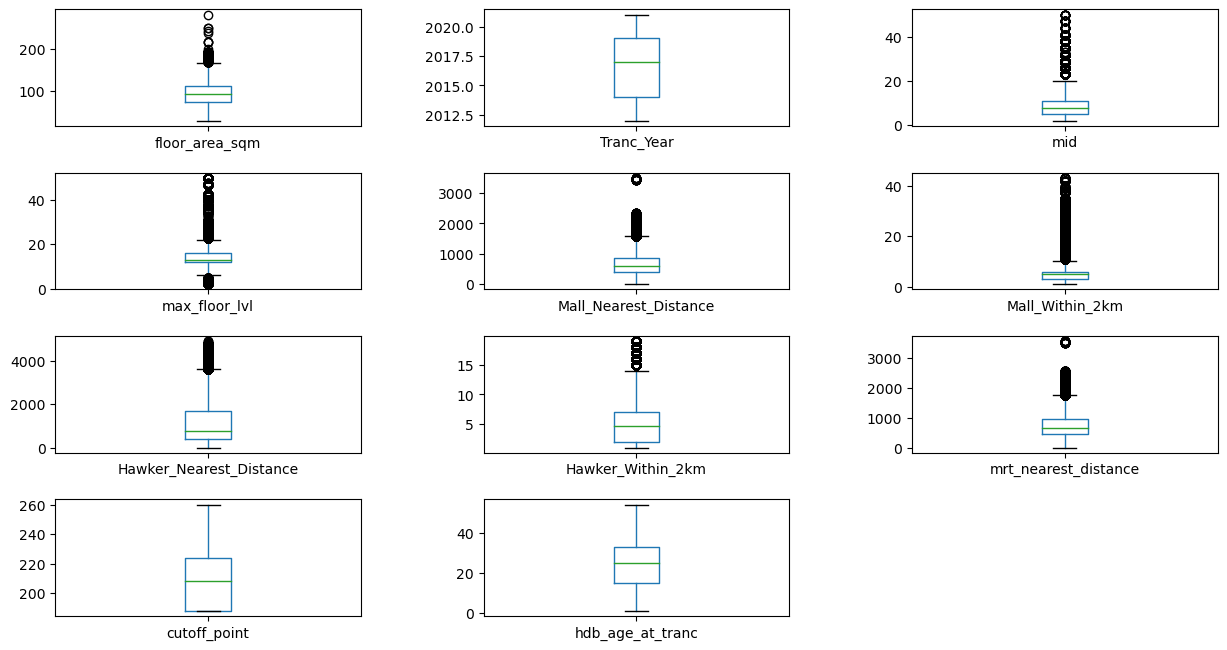

In [12]:
# Plot and interpret boxplots
fig2 = plt.figure(figsize=(15,10))
fig2.subplots_adjust(hspace=0.4,wspace=0.4)

for idx, d in enumerate(numerical_columns):
    fig2.add_subplot(5,3,idx+1)
    bp = df.boxplot(column=d, grid=False)

In [13]:
def calc_proportion(col=None, outlier=None, quantile=None):
    
    if outlier == 'low':
        df_outliers = df[df.resale_price <= df.resale_price.quantile(q=quantile)]
        
    elif outlier == 'high':
        df_outliers = df[df.resale_price >= df.resale_price.quantile(q=quantile)]
    
    info_by_feature = {}
    outliers_info = {}
    
    df_grouped = df.groupby(col).resale_price.describe().sort_values('mean')
    
    for feature, count, mean in zip(df_grouped.index, df_grouped['count'], df_grouped['mean']):
        info_by_feature[feature] = [count, mean]
        
    df_outliers = df_outliers.groupby(col).resale_price.describe().sort_values('mean')
    
    for feature, count, mean in zip(df_outliers.index, df_outliers['count'], df_outliers['mean']):
        outliers_info[feature] = [count, mean]
        
    proportion = {}
        
    for feature in outliers_info.keys():
        proportion[feature] = np.round(outliers_info[feature][0]/info_by_feature[feature][0]*100, 2)
        
    return pd.DataFrame(proportion.values(), index=proportion.keys(), columns=['proportion_in_percentage']).sort_values('proportion_in_percentage', ascending=False)

In [14]:
calc_proportion(col='flat_model', outlier='high', quantile=0.975)

proportion_in_percentage
Type S2                                   100.00
Type S1                                    93.39
Premium Apartment Loft                     88.00
Terrace                                    50.53
DBSS                                       34.92
Multi Generation                           26.79
Premium Maisonette                         26.67
Model A-Maisonette                         23.66
Adjoined flat                              18.08
Maisonette                                 13.41
Apartment                                   4.44
Standard                                    4.15
Improved                                    3.01
Premium Apartment                           0.81
Model A                                     0.62

In [15]:
# Set up X and y.
X= df[numerical_columns+categorical_columns]
y= df['resale_price']

nulls = {k:v for k,v in dict(X.isnull().sum()).items() if v>0}
for k,v in nulls.items():
    print(f"Empty rows in column [{k}]: {v}")

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.3,
                                                    random_state = 42)

In [55]:
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
numerical_preprocessor = StandardScaler()

preprocessor = ColumnTransformer([
    ('one-hot-encoder', categorical_preprocessor, categorical_columns),
    ('standard_scaler', numerical_preprocessor, numerical_columns)])

model = make_pipeline(preprocessor, LinearRegression()
)
model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('one-hot-encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['flat_type', 'flat_model',
                                                   'planning_area',
                                                   'bus_interchange',
                                                   'mrt_interchange']),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  ['floor_area_sqm',
                                                   'Tranc_Year', 'mid',
                                                   'max_floor_lvl',
                                                   'Mall_Nearest_Distance',
                                                   'Mall_Within_2km',
                                                   'Hawker_Nearest_Distance',
                                                   'Hawker_Within_2km',
                                                   'mrt_nearest_distance',
                                                   'cutoff_point',
                                                   'hdb_age_at_tranc'])])),
                ('linearregression', LinearRegression())])

In [56]:
#Fit
model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('one-hot-encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['flat_type', 'flat_model',
                                                   'planning_area',
                                                   'bus_interchange',
                                                   'mrt_interchange']),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  ['floor_area_sqm',
                                                   'Tranc_Year', 'mid',
                                                   'max_floor_lvl',
                                                   'Mall_Nearest_Distance',
                                                   'Mall_Within_2km',
                                                   'Hawker_Nearest_Distance',
                                                   'Hawker_Within_2km',
                                                   'mrt_nearest_distance',
                                                   'cutoff_point',
                                                   'hdb_age_at_tranc'])])),
                ('linearregression', LinearRegression())])

In [57]:
model.score(X_train,y_train)

0.8838112865389017

In [58]:
# Evaluate.
model.score(X_test,y_test)

0.8836425829249676

In [59]:
model.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('one-hot-encoder',
                                    OneHotEncoder(handle_unknown='ignore'),
                                    ['flat_type', 'flat_model', 'planning_area',
                                     'bus_interchange', 'mrt_interchange']),
                                   ('standard_scaler', StandardScaler(),
                                    ['floor_area_sqm', 'Tranc_Year', 'mid',
                                     'max_floor_lvl', 'Mall_Nearest_Distance',
                                     'Mall_Within_2km', 'Hawker_Nearest_Distance',
                                     'Hawker_Within_2km', 'mrt_nearest_distance',
                                     'cutoff_point', 'hdb_age_at_tranc'])])),
  ('linearregression', LinearRegression())],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('one-hot-encoder',
                                  OneHotEncoder(hand

In [60]:
cv_results = cross_validate(model, X_train, y_train, cv=5)
scores = cv_results["test_score"]
print("The mean cross-validation accuracy is: "
      f"{scores.mean():.3f} ± {scores.std():.3f}")

The mean cross-validation accuracy is: 0.884 ± 0.001


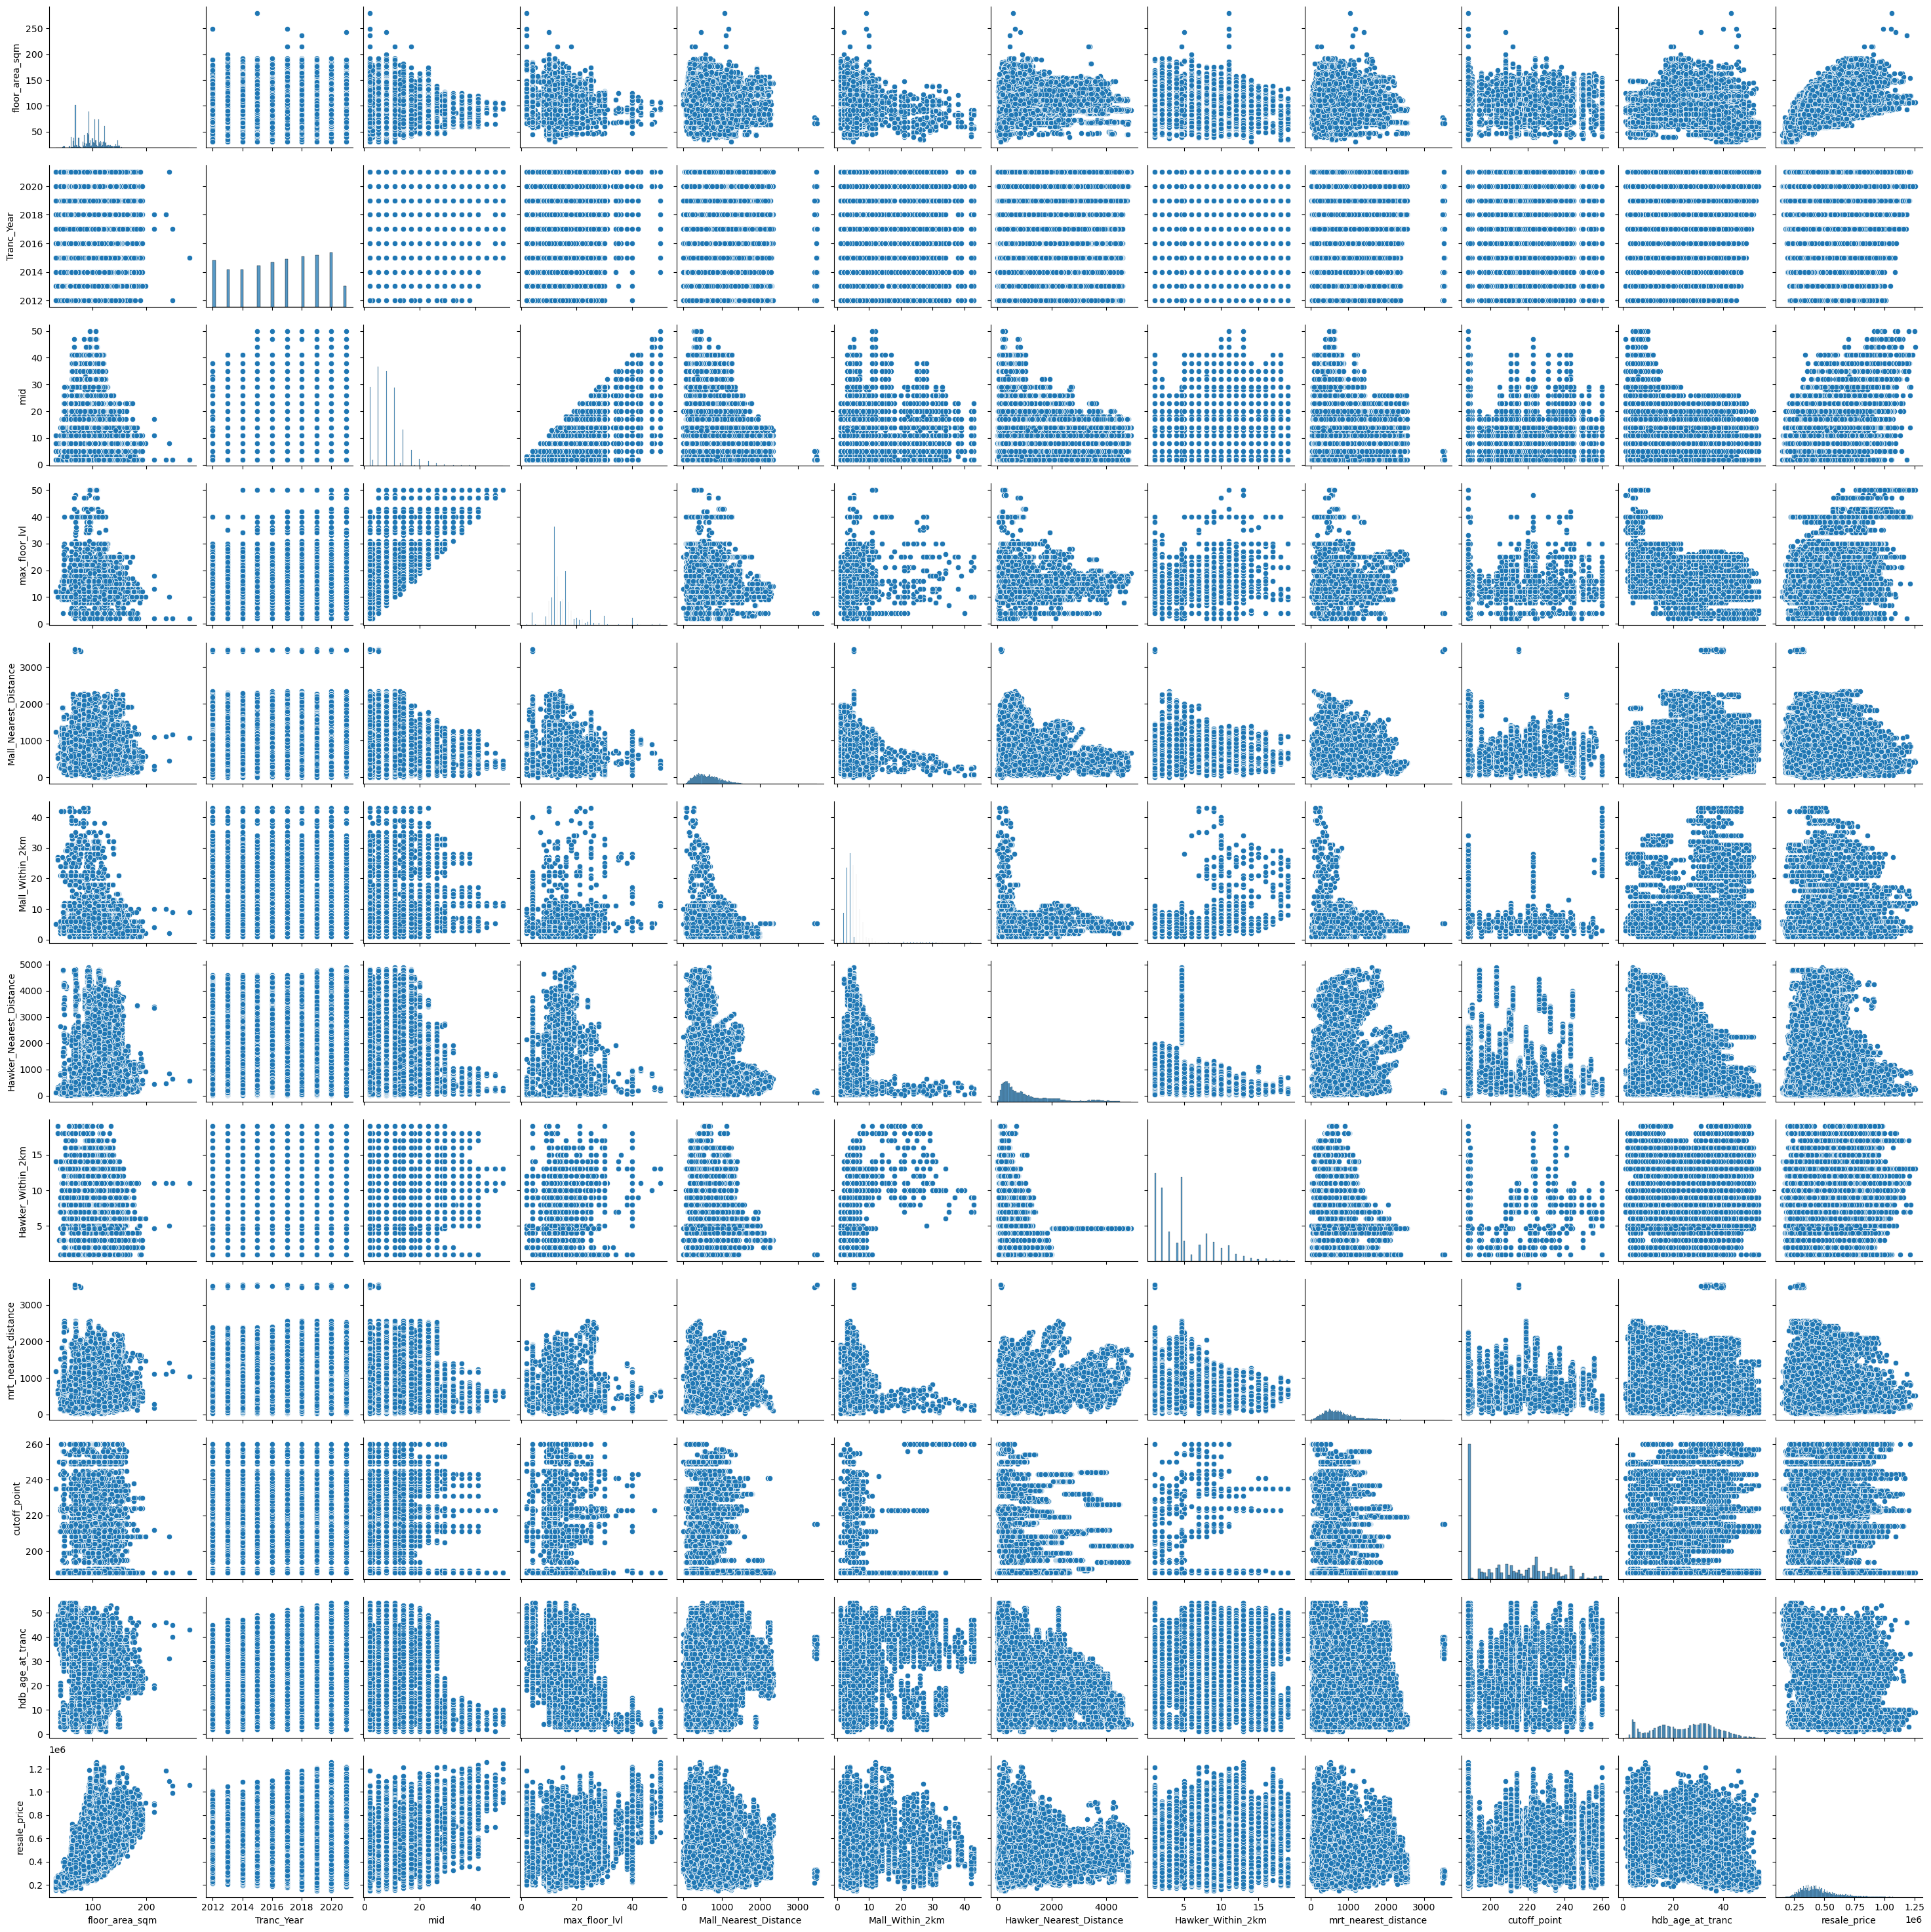

In [24]:

sns.pairplot(df[numerical_columns+['resale_price']])

In [61]:
def get_feature_names():  
    column_transformer = preprocessor      
    new_feature_names = []
    for i, transformer_item in enumerate(column_transformer.transformers_):        
        transformer_name, transformer, orig_feature_names = transformer_item
        orig_feature_names = list(orig_feature_names)                
        if hasattr(transformer, 'get_feature_names'):
            if 'input_features' in transformer.get_feature_names.__code__.co_varnames:
                names = list(transformer.get_feature_names(orig_feature_names))
            else:
                names = list(transformer.get_feature_names())
        new_feature_names.extend(names)       
    return new_feature_names

get_feature_names()

C:\Users\zttan\anaconda3\envs\dsi-sg\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['x0_1 ROOM',
 'x0_2 ROOM',
 'x0_3 ROOM',
 'x0_4 ROOM',
 'x0_5 ROOM',
 'x0_EXECUTIVE',
 'x0_MULTI-GENERATION',
 'x1_2-room',
 'x1_Adjoined flat',
 'x1_Apartment',
 'x1_DBSS',
 'x1_Improved',
 'x1_Improved-Maisonette',
 'x1_Maisonette',
 'x1_Model A',
 'x1_Model A-Maisonette',
 'x1_Model A2',
 'x1_Multi Generation',
 'x1_New Generation',
 'x1_Premium Apartment',
 'x1_Premium Apartment Loft',
 'x1_Premium Maisonette',
 'x1_Simplified',
 'x1_Standard',
 'x1_Terrace',
 'x1_Type S1',
 'x1_Type S2',
 'x2_Ang Mo Kio',
 'x2_Bedok',
 'x2_Bishan',
 'x2_Bukit Batok',
 'x2_Bukit Merah',
 'x2_Bukit Panjang',
 'x2_Bukit Timah',
 'x2_Changi',
 'x2_Choa Chu Kang',
 'x2_Clementi',
 'x2_Downtown Core',
 'x2_Geylang',
 'x2_Hougang',
 'x2_Jurong East',
 'x2_Jurong West',
 'x2_Kallang',
 'x2_Marine Parade',
 'x2_Novena',
 'x2_Outram',
 'x2_Pasir Ris',
 'x2_Punggol',
 'x2_Queenstown',
 'x2_Rochor',
 'x2_Sembawang',
 'x2_Sengkang',
 'x2_Serangoon',
 'x2_Tampines',
 'x2_Tanglin',
 'x2_Toa Payoh',
 'x2_Western

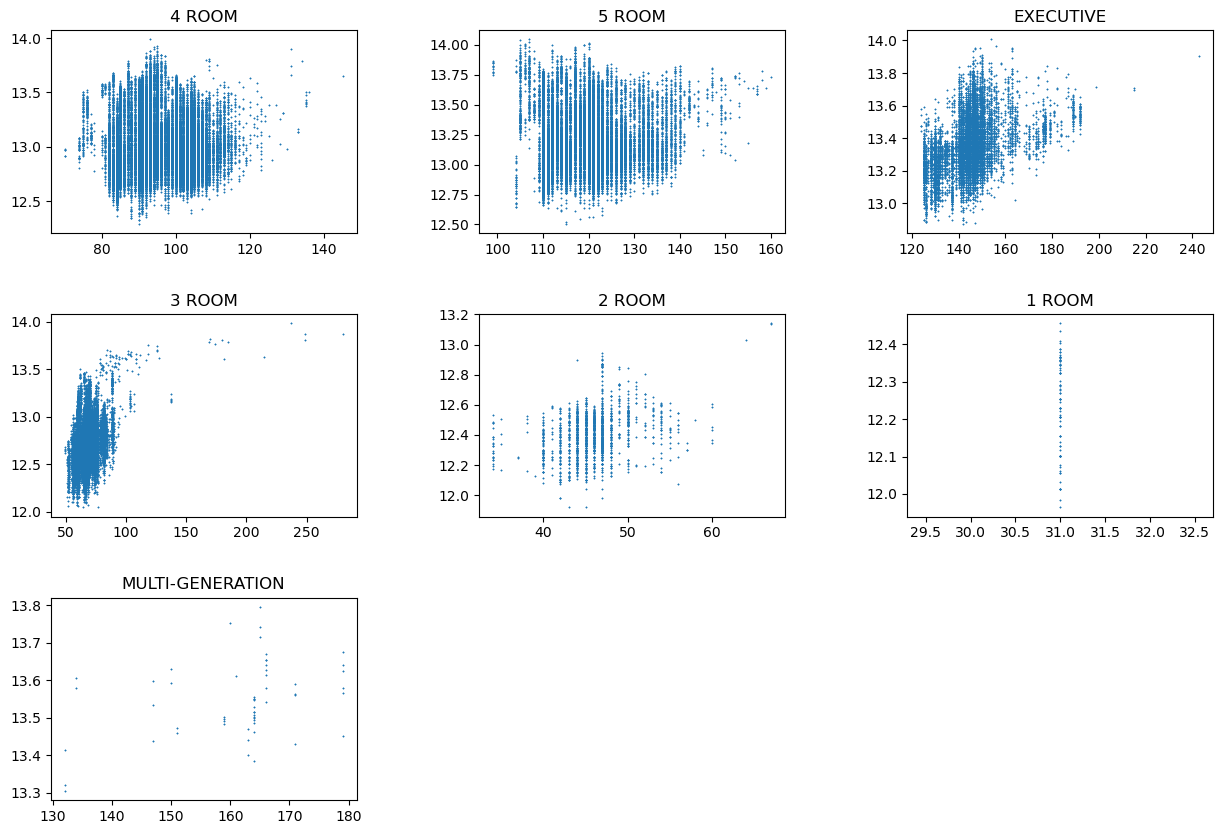

In [26]:
fig3 = plt.figure(figsize=(15,10))
fig3.subplots_adjust(hspace=0.4,wspace=0.4)

for idx, d in enumerate(df['flat_type'].unique()):
    x = df.loc[df['flat_type']==d]['floor_area_sqm']
    y = np.log(df.loc[df['flat_type']==d]['resale_price'])
    fig3.add_subplot(3,3,idx+1)
    plt.scatter(x,y, marker='*',s=0.1)
    plt.title(d)